# 1. Data preparation

In [1]:
from model.model import load_trained_model

model = load_trained_model('picasso_test_rgb')

In [2]:
%load_ext autoreload
%autoreload 2

from data.datasets import TrainingPicassoDataset
from config.datasets import dataset_configs

z_range = 1000
dataset = 'picasso_test'
train_dataset = TrainingPicassoDataset(dataset_configs[dataset]['training'], z_range, add_noise=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]



Loaded spots...
(41, 512, 512) (512, 512)
Aligning (94, 41, 31, 31) psfs...


100%|██████████| 93/93 [04:44<00:00,  3.06s/it]


Prepared stacks...


In [3]:
from skimage.transform import resize
import numpy as np
import tensorflow as tf
for k in train_dataset.data.keys():
    print(k, train_dataset.data[k][0][0].shape)
    train_dataset.data[k][0][0] = tf.image.grayscale_to_rgb(tf.convert_to_tensor(train_dataset.data[k][0][0])).numpy()
    n_channels = train_dataset.data[k][0][0].shape[-1]
    train_dataset.data[k][0][0] = np.stack([resize(img, (32, 32, n_channels), anti_aliasing=True) for img in train_dataset.data[k][0][0]])
    print(k, train_dataset.data[k][0][0].shape)

train (2493, 31, 31, 1)
train (2493, 32, 32, 3)
val (712, 31, 31, 1)
val (712, 32, 32, 3)
test (357, 31, 31, 1)
test (357, 32, 32, 3)


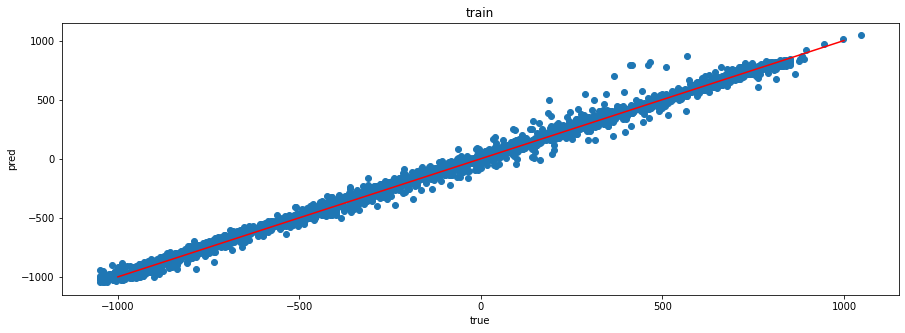

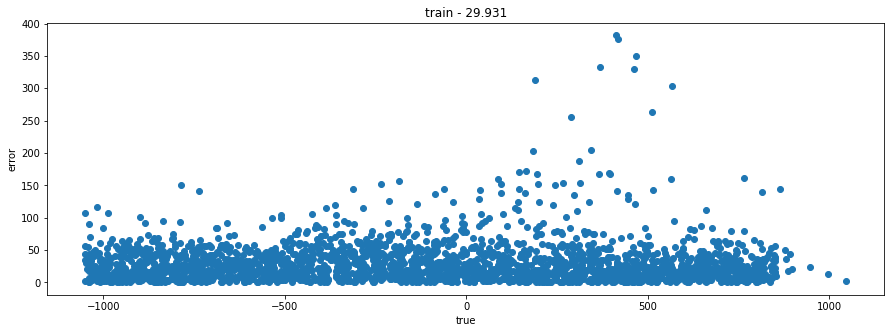

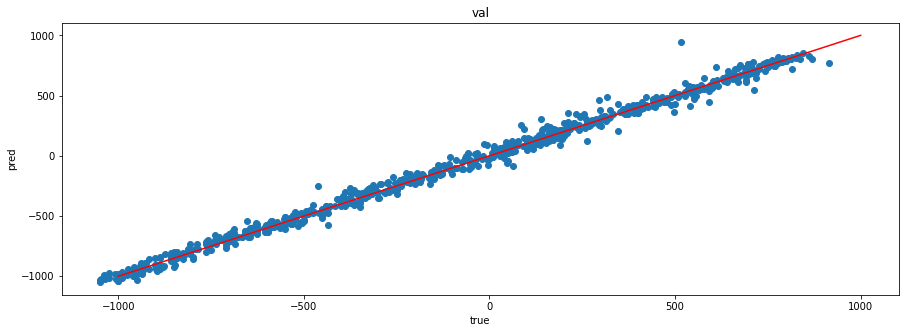

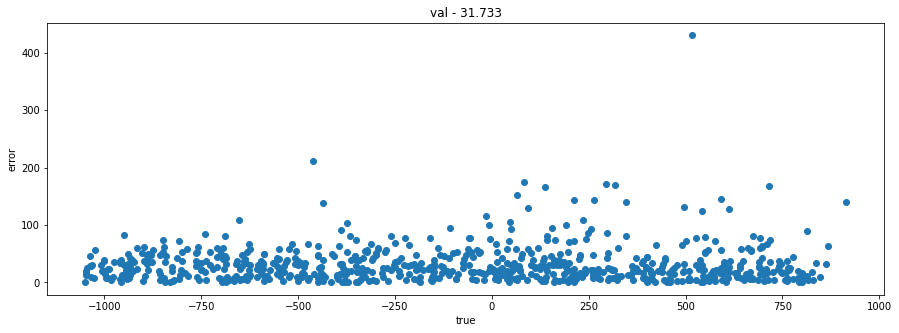

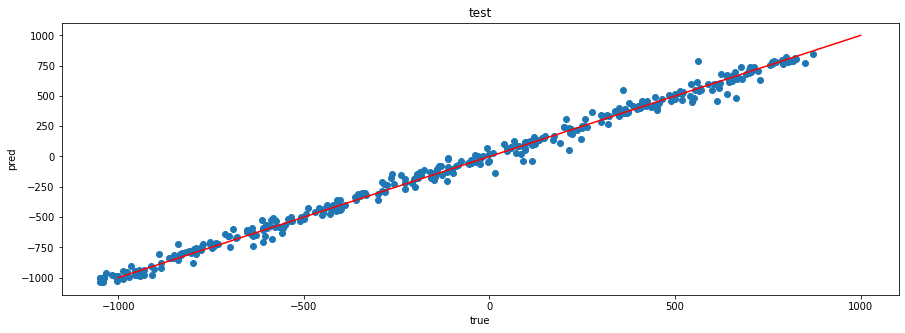

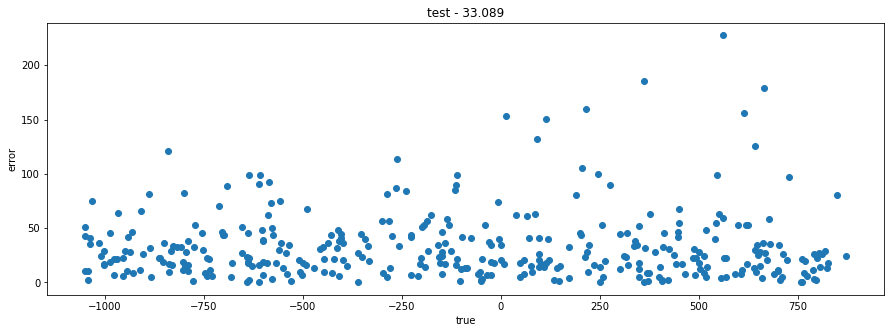

In [4]:
for k in ('train', 'val', 'test'):
    x, y = train_dataset.data[k]
    pred_y = model.predict(x).squeeze()
    plt.scatter(y, pred_y)
    plt.plot([-1000, 1000], [-1000, 1000], c='red')
    plt.title(k)
    plt.ylabel('pred')
    plt.xlabel('true')
    plt.show()
    errors = abs(y - pred_y)
    
    mean_abs_error = np.mean(errors)
    plt.scatter(y, errors)
    plt.title(f'{k} - {round(mean_abs_error, 3)}')
    plt.ylabel('error')
    plt.xlabel('true')
    plt.show()
    

In [5]:
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse

from data.datasets import mask_img_stack
from multiprocessing import Pool

def do_ssim(data):
    i, i2, im1, im2 = data
    return i, i2, mse(im1, im2)

def get_imgs_at_depth(z):
    idx = np.argwhere(abs(train_dataset.data['train'][1].squeeze()-z) < 10).squeeze()
    return train_dataset.data['train'][0][0][idx]

def get_pairwise_ssims(imgs):
    n_imgs = imgs.shape[0]

    datasets = []
    for i in range(0, n_imgs):
        for i2 in range(i, n_imgs):
            datasets.append((i, i2, imgs[i], imgs[i2]))

    with Pool(16) as p:
        r = list(tqdm(p.imap(do_ssim, datasets), total=len(datasets)))

    ssims = np.zeros((n_imgs, n_imgs))
    
    for res in r:
        i, i2, val = res
        ssims[i][i2] = val
        ssims[i2][i] = val
    return ssims
    

imgs = train_dataset.data['train'][0][0]
z_coords = train_dataset.data['train'][1]

idx = np.argwhere(abs(z_coords % 250) < 15).squeeze()
imgs = imgs[idx]
z_coords = z_coords[idx]

masked_imgs = mask_img_stack(imgs.mean(axis=-1), radius=8)
ssims = get_pairwise_ssims(masked_imgs)



100%|██████████| 24310/24310 [00:01<00:00, 13607.23it/s]


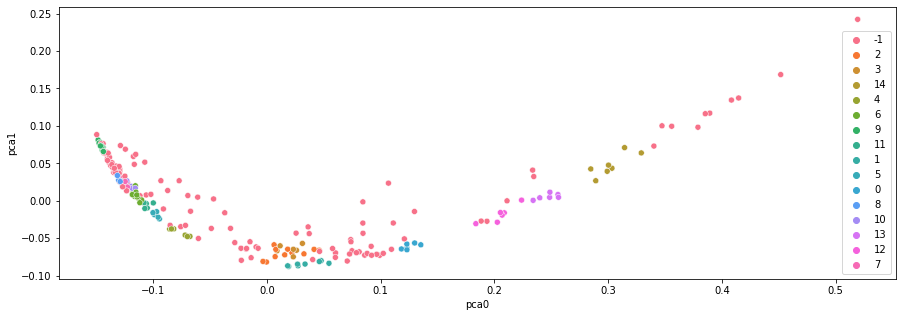

Rows 1 Cols 10 n_spaces 10 n_psfs 6
-992.0 5.627314338711377
[ -988.  -986. -1000.  -999.  -987.  -992.]
[ -902.88934 -1027.9336  -1060.8457  -1031.4729  -1002.1895  -1032.3806 ]


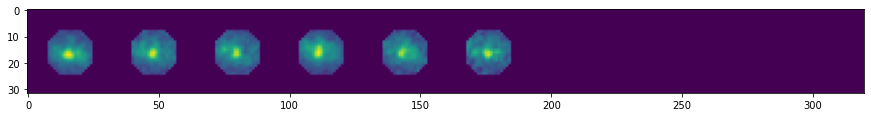

Rows 1 Cols 10 n_spaces 10 n_psfs 8
-963.125 80.62635657773455
[ -991. -1000.  -994.  -989.  -750.  -997.  -994.  -990.]
[ -972.52435 -1031.7072  -1036.5446  -1026.0671   -802.1402  -1041.9381
 -1019.1217  -1026.9032 ]


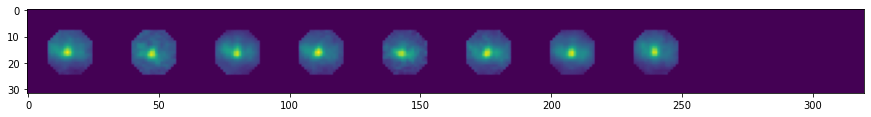

Rows 2 Cols 10 n_spaces 20 n_psfs 11
-742.7272727272727 4.788070575368615
[-739. -750. -745. -739. -750. -739. -746. -736. -738. -747. -741.]
[-707.62256 -812.82837 -754.6419  -727.4819  -770.8728  -763.80994
 -808.4636  -735.36615 -745.651   -782.0243  -773.7632 ]


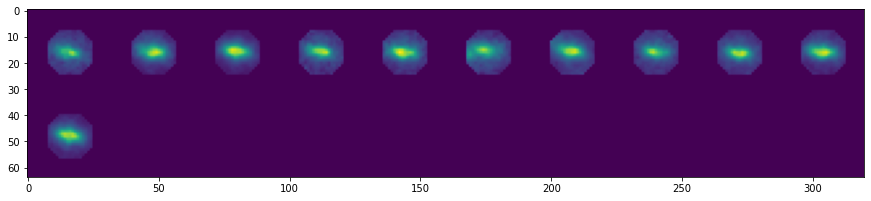

Rows 1 Cols 10 n_spaces 10 n_psfs 6
505.1666666666667 4.2196629670573875
[503. 501. 500. 506. 511. 510.]
[482.85397 464.0415  457.94763 439.51456 501.23557 461.6319 ]


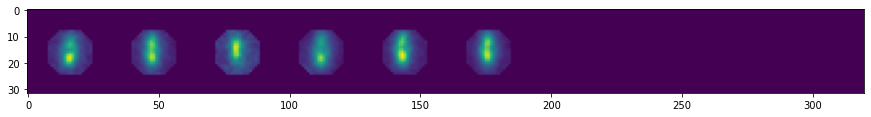

Rows 1 Cols 10 n_spaces 10 n_psfs 7
-528.2857142857143 88.22489814707198
[-487. -492. -486. -744. -489. -500. -500.]
[-524.64435 -533.3426  -604.5574  -776.3064  -542.6251  -570.21265
 -544.79297]


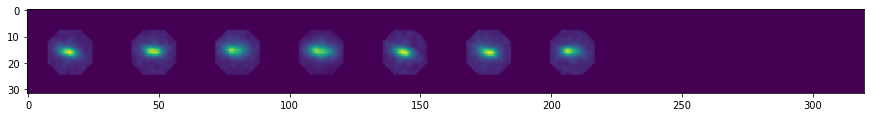

Rows 1 Cols 10 n_spaces 10 n_psfs 5
-493.0 4.979959839195475
[-489. -500. -498. -490. -488.]
[-529.227   -553.49365 -537.52563 -491.78278 -553.00024]


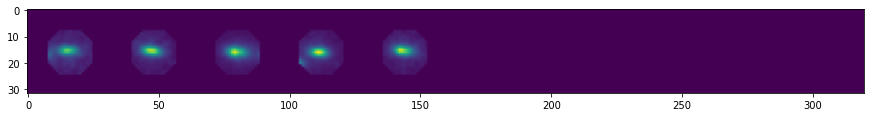

Rows 1 Cols 10 n_spaces 10 n_psfs 10
-468.0 77.50612878992217
[-236. -496. -500. -488. -491. -486. -500. -499. -487. -497.]
[-438.04462 -550.8998  -553.65826 -479.76413 -544.7844  -570.4597
 -504.18323 -535.49274 -553.28284 -550.8871 ]


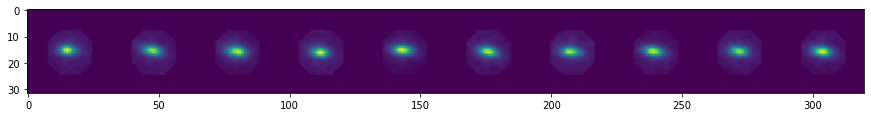

Rows 1 Cols 10 n_spaces 10 n_psfs 5
-494.2 2.78567765543687
[-494. -495. -492. -499. -491.]
[-517.73816 -498.75287 -444.77325 -519.0765  -509.5944 ]


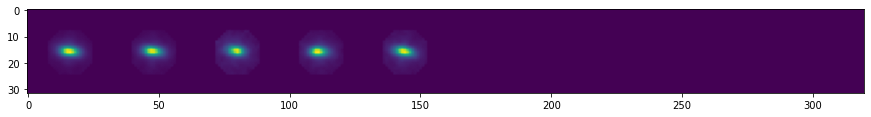

Rows 1 Cols 10 n_spaces 10 n_psfs 6
6.9999999999999245 5.099019513592711
[12. 11.  8.  0. 11.  0.]
[ 42.296703  -5.757913  18.249195 -86.183945  17.07656  -61.725155]


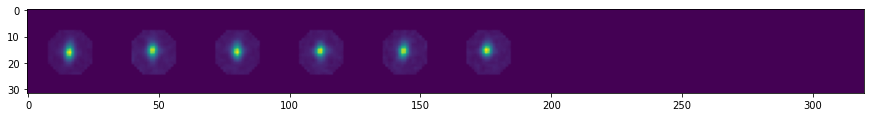

Rows 2 Cols 10 n_spaces 20 n_psfs 11
-244.72727272727272 4.201534548469579
[-244. -244. -240. -245. -247. -241. -236. -246. -249. -250. -250.]
[-248.77205 -223.2493  -261.7885  -239.25758 -263.98657 -246.31516
 -269.85355 -235.23483 -264.4782  -251.99335 -279.94244]


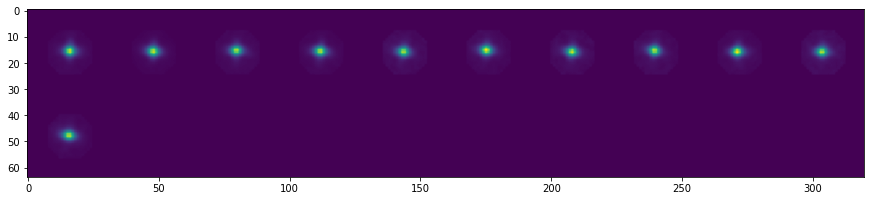

Rows 1 Cols 10 n_spaces 10 n_psfs 5
253.6 2.939387691339814
[251. 253. 254. 251. 259.]
[189.34943 194.76326 201.10524 168.69415 280.49896]


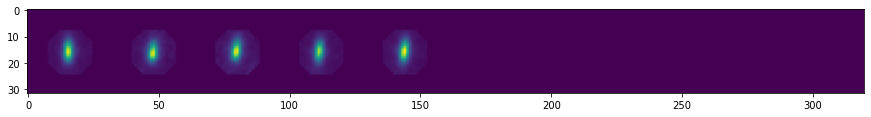

Rows 1 Cols 10 n_spaces 10 n_psfs 6
257.3333333333335 5.467073155619065
[258. 263. 250. 263. 260. 250.]
[225.25212 260.0144  212.92467 181.67245 239.90216 153.01205]


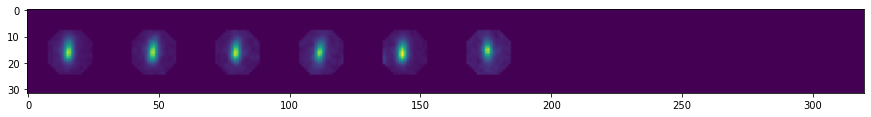

Rows 1 Cols 10 n_spaces 10 n_psfs 6
422.1666666666667 642.2627750556794
[  750. -1000.   511.   756.   752.   764.]
[  714.5392  -1026.4961    752.8159    724.4622    720.67474   653.18964]


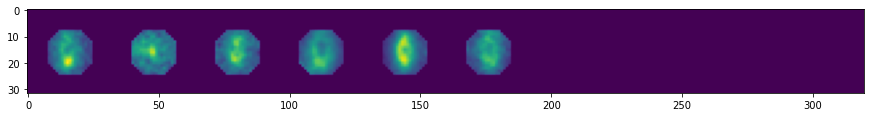

Rows 1 Cols 10 n_spaces 10 n_psfs 6
755.1666666666666 5.367080729368317
[750. 750. 760. 758. 750. 763.]
[709.31836 732.3158  697.8721  681.0284  657.54877 739.95844]


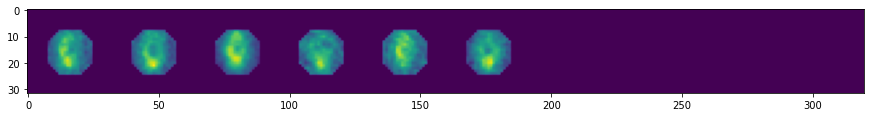

Rows 1 Cols 10 n_spaces 10 n_psfs 7
718.0 84.9789889998026
[759. 751. 756. 750. 510. 750. 750.]
[742.98596 732.29846 727.1719  725.15356 509.36115 717.28076 709.61804]


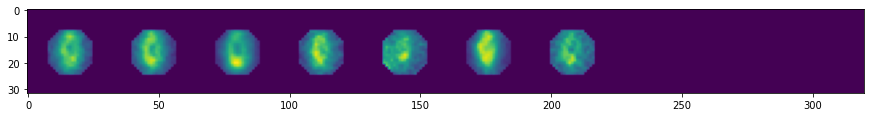

In [6]:
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS
from data.visualise import grid_psfs

clusters = OPTICS().fit_predict(ssims)

pca = PCA(n_components=2).fit_transform(ssims)
data = pd.DataFrame.from_dict({
    'pca0': pca[:, 0],
    'pca1': pca[:, 1],
    'zs': z_coords,
    'cid': clusters
})
sns.scatterplot(data=data, x='pca0', y='pca1', hue=clusters.astype(str))
plt.show()

for cid in set(clusters):
    if cid == -1:
        continue
    idx = np.argwhere(clusters==cid).squeeze()
    group_imgs = masked_imgs[idx]
    group_zcoords = z_coords[idx]
    
    pred_z = model.predict((imgs[idx], np.zeros((imgs[idx].shape[0], 2))))
    plt.imshow(grid_psfs(group_imgs))
    print(np.mean(group_zcoords), np.std(group_zcoords))
    print(group_zcoords)
    print(pred_z.squeeze())
    plt.show()

100%|██████████| 2493/2493 [00:00<00:00, 3220.37it/s]


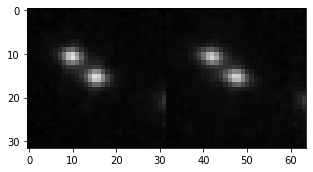

Rows 3 Cols 10 n_spaces 30 n_psfs 29


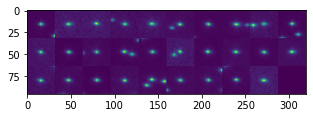

 13%|█▎        | 331/2493 [00:00<00:00, 3302.08it/s]

True: -343.0 Pred: [-302.79733] Closest ground truth -393.0










100%|██████████| 2493/2493 [00:00<00:00, 3259.94it/s]


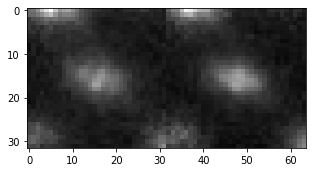

Rows 3 Cols 10 n_spaces 30 n_psfs 30


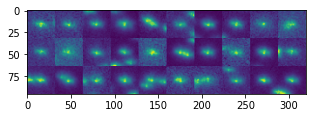

 13%|█▎        | 328/2493 [00:00<00:00, 3270.43it/s]

True: -886.0 Pred: [-917.9233] Closest ground truth -836.0










100%|██████████| 2493/2493 [00:00<00:00, 3274.62it/s]


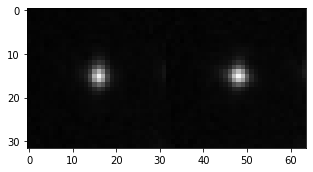

Rows 3 Cols 10 n_spaces 30 n_psfs 27


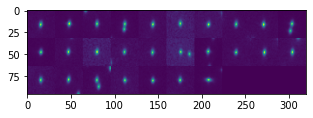

 13%|█▎        | 330/2493 [00:00<00:00, 3293.60it/s]

True: 91.0 Pred: [-40.974953] Closest ground truth -9.0










100%|██████████| 2493/2493 [00:00<00:00, 3290.87it/s]


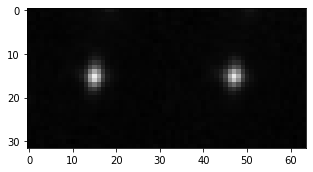

Rows 2 Cols 10 n_spaces 20 n_psfs 18


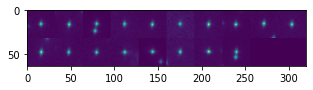

 13%|█▎        | 329/2493 [00:00<00:00, 3287.05it/s]

True: -17.0 Pred: [1.0154148] Closest ground truth -67.0










100%|██████████| 2493/2493 [00:00<00:00, 3279.64it/s]


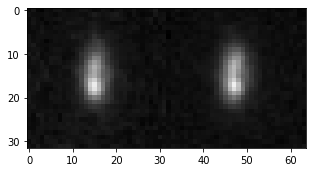

Rows 3 Cols 10 n_spaces 30 n_psfs 25


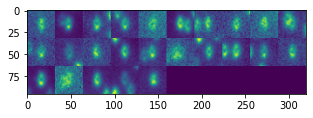

 13%|█▎        | 324/2493 [00:00<00:00, 3231.32it/s]

True: 664.0 Pred: [484.93134] Closest ground truth 461.0










100%|██████████| 2493/2493 [00:00<00:00, 3289.35it/s]


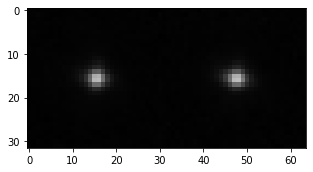

Rows 2 Cols 10 n_spaces 20 n_psfs 20


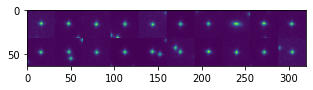

 13%|█▎        | 327/2493 [00:00<00:00, 3264.26it/s]

True: -150.0 Pred: [-178.13333] Closest ground truth -200.0










100%|██████████| 2493/2493 [00:00<00:00, 3283.13it/s]


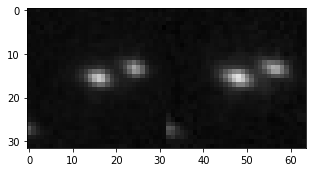

Rows 3 Cols 10 n_spaces 30 n_psfs 29


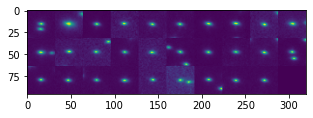

 13%|█▎        | 327/2493 [00:00<00:00, 3267.92it/s]

True: -404.0 Pred: [-359.7705] Closest ground truth -504.0










100%|██████████| 2493/2493 [00:00<00:00, 3282.59it/s]


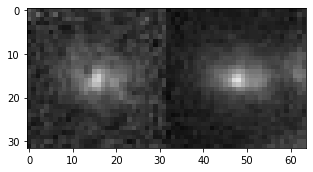

Rows 3 Cols 10 n_spaces 30 n_psfs 29


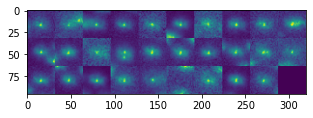

 13%|█▎        | 331/2493 [00:00<00:00, 3300.86it/s]

True: -1003.0 Pred: [-986.12646] Closest ground truth -809.0










100%|██████████| 2493/2493 [00:00<00:00, 3299.04it/s]


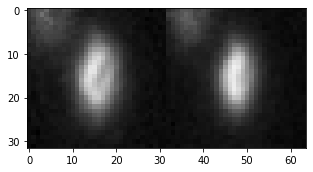

Rows 1 Cols 10 n_spaces 10 n_psfs 3


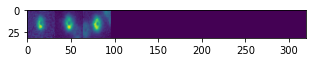

 13%|█▎        | 317/2493 [00:00<00:00, 3168.07it/s]

True: 872.0 Pred: [847.22217] Closest ground truth 772.0










100%|██████████| 2493/2493 [00:00<00:00, 3280.45it/s]


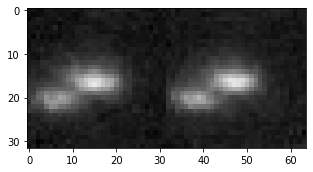

Rows 3 Cols 10 n_spaces 30 n_psfs 29


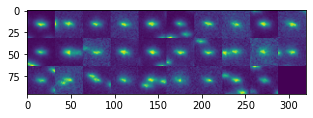

 13%|█▎        | 331/2493 [00:00<00:00, 3307.67it/s]

True: -790.0 Pred: [-773.52405] Closest ground truth -740.0










100%|██████████| 2493/2493 [00:00<00:00, 3274.27it/s]


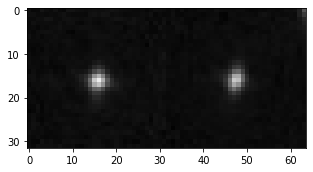

Rows 3 Cols 10 n_spaces 30 n_psfs 21


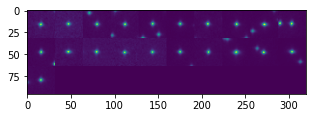

 13%|█▎        | 329/2493 [00:00<00:00, 3284.91it/s]

True: -127.0 Pred: [-155.95947] Closest ground truth -36.999999999999545










100%|██████████| 2493/2493 [00:00<00:00, 3290.70it/s]


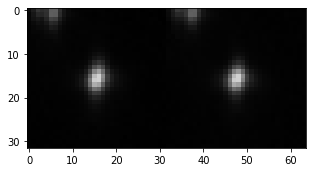

Rows 2 Cols 10 n_spaces 20 n_psfs 20


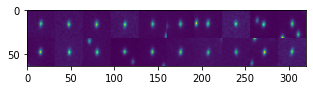

 13%|█▎        | 325/2493 [00:00<00:00, 3242.34it/s]

True: 122.0 Pred: [101.254486] Closest ground truth 72.0










100%|██████████| 2493/2493 [00:00<00:00, 3311.67it/s]


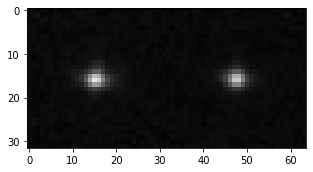

Rows 3 Cols 10 n_spaces 30 n_psfs 29


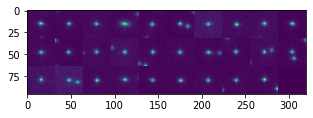

 13%|█▎        | 326/2493 [00:00<00:00, 3254.44it/s]

True: -200.0 Pred: [-250.93114] Closest ground truth -229.0










100%|██████████| 2493/2493 [00:00<00:00, 3298.34it/s]


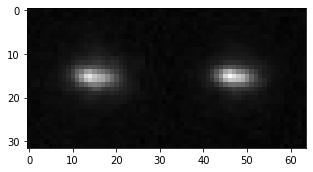

Rows 2 Cols 10 n_spaces 20 n_psfs 19


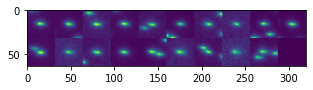

 13%|█▎        | 326/2493 [00:00<00:00, 3259.05it/s]

True: -639.0 Pred: [-593.77905] Closest ground truth -589.0










100%|██████████| 2493/2493 [00:00<00:00, 3272.57it/s]


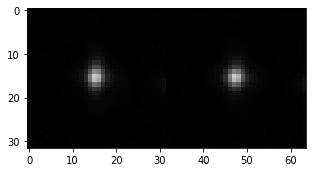

Rows 2 Cols 10 n_spaces 20 n_psfs 14


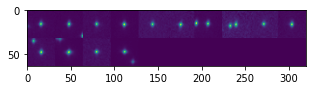

 13%|█▎        | 329/2493 [00:00<00:00, 3287.53it/s]

True: -25.0 Pred: [-17.660242] Closest ground truth -75.0










100%|██████████| 2493/2493 [00:00<00:00, 3296.08it/s]


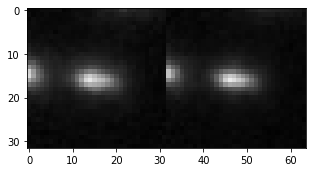

Rows 3 Cols 10 n_spaces 30 n_psfs 21


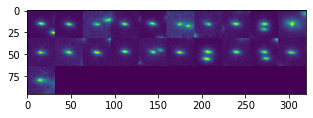

 13%|█▎        | 326/2493 [00:00<00:00, 3253.22it/s]

True: -610.0000000000002 Pred: [-610.2699] Closest ground truth -560.0000000000002










100%|██████████| 2493/2493 [00:00<00:00, 3265.94it/s]


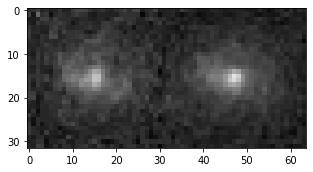

Rows 3 Cols 10 n_spaces 30 n_psfs 29


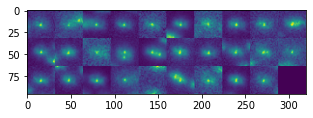

 13%|█▎        | 330/2493 [00:00<00:00, 3292.61it/s]

True: -1002.0 Pred: [-985.5294] Closest ground truth -886.0










100%|██████████| 2493/2493 [00:00<00:00, 3276.27it/s]


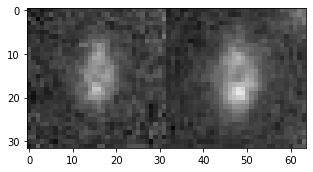

Rows 3 Cols 10 n_spaces 30 n_psfs 24


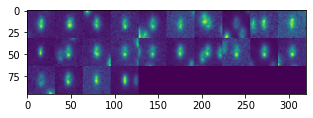

 13%|█▎        | 334/2493 [00:00<00:00, 3338.44it/s]

True: 561.0 Pred: [788.4729] Closest ground truth 740.0










100%|██████████| 2493/2493 [00:00<00:00, 3305.57it/s]


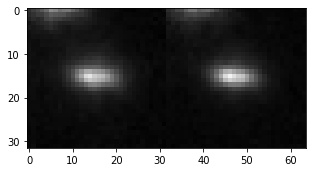

Rows 4 Cols 10 n_spaces 40 n_psfs 31


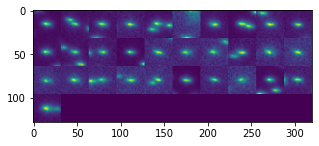

 13%|█▎        | 329/2493 [00:00<00:00, 3286.99it/s]

True: -691.0 Pred: [-602.56226] Closest ground truth -641.0










100%|██████████| 2493/2493 [00:00<00:00, 3304.44it/s]


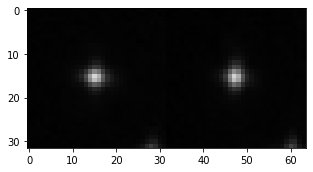

Rows 3 Cols 10 n_spaces 30 n_psfs 30


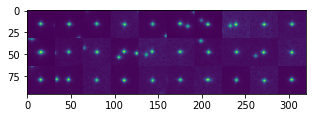

 13%|█▎        | 323/2493 [00:00<00:00, 3227.84it/s]

True: -184.0 Pred: [-154.70134] Closest ground truth -84.0










100%|██████████| 2493/2493 [00:00<00:00, 3306.55it/s]


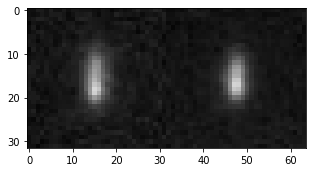

Rows 3 Cols 10 n_spaces 30 n_psfs 28


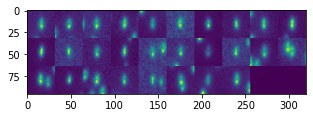

 13%|█▎        | 331/2493 [00:00<00:00, 3302.01it/s]

True: 500.0 Pred: [472.26648] Closest ground truth 327.0










100%|██████████| 2493/2493 [00:00<00:00, 3295.93it/s]


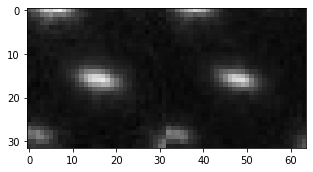

Rows 2 Cols 10 n_spaces 20 n_psfs 20


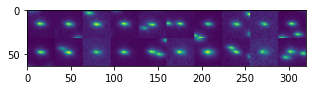

 13%|█▎        | 330/2493 [00:00<00:00, 3292.08it/s]

True: -636.0 Pred: [-658.38306] Closest ground truth -586.0










100%|██████████| 2493/2493 [00:00<00:00, 3262.03it/s]


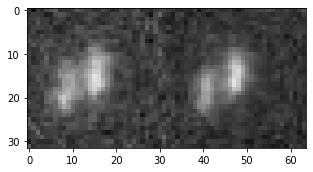

Rows 3 Cols 10 n_spaces 30 n_psfs 24


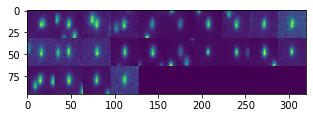

 13%|█▎        | 328/2493 [00:00<00:00, 3275.93it/s]

True: 410.0 Pred: [442.3418] Closest ground truth 360.0










100%|██████████| 2493/2493 [00:00<00:00, 3269.77it/s]


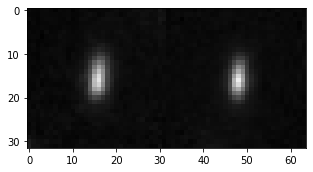

Rows 2 Cols 10 n_spaces 20 n_psfs 18


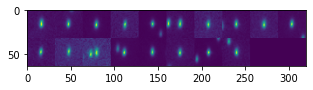

 13%|█▎        | 330/2493 [00:00<00:00, 3294.00it/s]

True: 275.0 Pred: [365.03372] Closest ground truth 241.0










100%|██████████| 2493/2493 [00:00<00:00, 3289.89it/s]


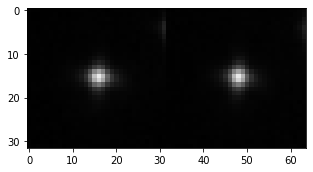

Rows 4 Cols 10 n_spaces 40 n_psfs 33


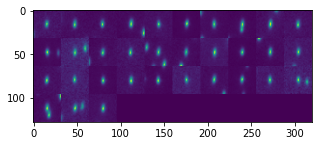

 13%|█▎        | 328/2493 [00:00<00:00, 3271.22it/s]

True: 246.0 Pred: [146.5301] Closest ground truth 296.0










100%|██████████| 2493/2493 [00:00<00:00, 3251.41it/s]


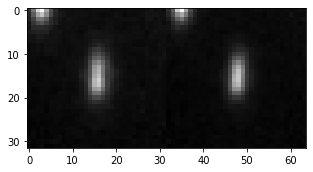

Rows 4 Cols 10 n_spaces 40 n_psfs 35


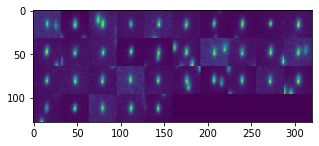

 13%|█▎        | 322/2493 [00:00<00:00, 3211.52it/s]

True: 348.0 Pred: [342.8502] Closest ground truth 298.0










100%|██████████| 2493/2493 [00:00<00:00, 3283.30it/s]


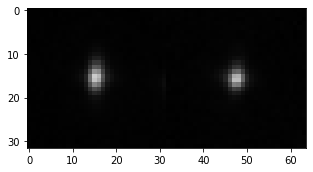

Rows 2 Cols 10 n_spaces 20 n_psfs 14


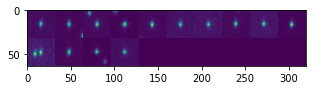

 13%|█▎        | 333/2493 [00:00<00:00, 3325.04it/s]

True: 75.0 Pred: [90.05787] Closest ground truth 0.0










100%|██████████| 2493/2493 [00:00<00:00, 3234.48it/s]


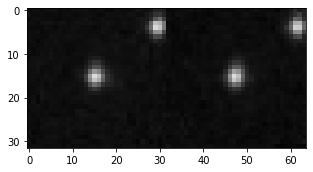

Rows 3 Cols 10 n_spaces 30 n_psfs 26


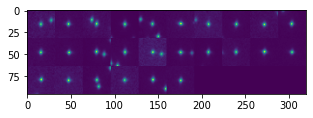

 13%|█▎        | 312/2493 [00:00<00:00, 3112.77it/s]

True: -50.0 Pred: [-52.01242] Closest ground truth 0.0










100%|██████████| 2493/2493 [00:00<00:00, 3156.96it/s]


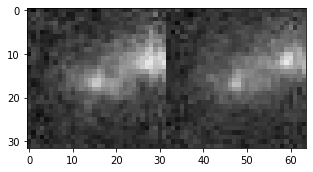

Rows 3 Cols 10 n_spaces 30 n_psfs 29


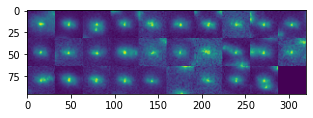

 12%|█▏        | 307/2493 [00:00<00:00, 3064.81it/s]

True: -954.0 Pred: [-976.462] Closest ground truth -1004.0










100%|██████████| 2493/2493 [00:00<00:00, 2939.60it/s]


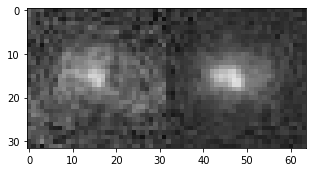

Rows 2 Cols 10 n_spaces 20 n_psfs 13


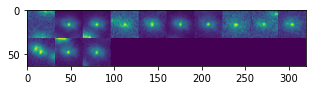

 13%|█▎        | 312/2493 [00:00<00:00, 3116.30it/s]

True: -1050.0 Pred: [-999.29926] Closest ground truth -928.0










100%|██████████| 2493/2493 [00:00<00:00, 3129.24it/s]


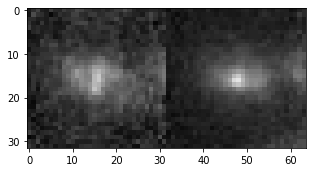

Rows 3 Cols 10 n_spaces 30 n_psfs 22


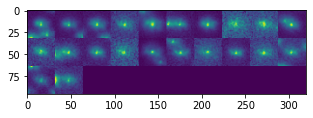

 13%|█▎        | 313/2493 [00:00<00:00, 3128.93it/s]

True: -977.0 Pred: [-955.02686] Closest ground truth -809.0










100%|██████████| 2493/2493 [00:00<00:00, 3094.70it/s]


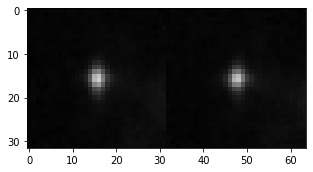

Rows 2 Cols 10 n_spaces 20 n_psfs 18


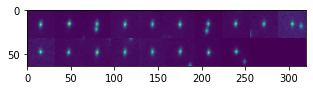

 13%|█▎        | 313/2493 [00:00<00:00, 3129.98it/s]

True: 85.0 Pred: [22.364101] Closest ground truth 35.0










100%|██████████| 2493/2493 [00:00<00:00, 3170.62it/s]


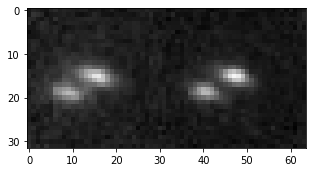

Rows 2 Cols 10 n_spaces 20 n_psfs 20


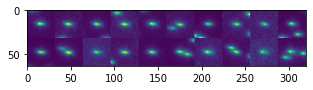

 13%|█▎        | 322/2493 [00:00<00:00, 3215.04it/s]

True: -639.9999999999998 Pred: [-621.98193] Closest ground truth -539.9999999999998










100%|██████████| 2493/2493 [00:00<00:00, 3173.27it/s]


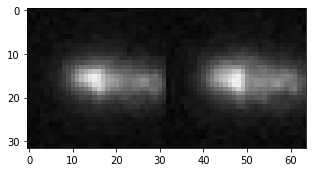

Rows 3 Cols 10 n_spaces 30 n_psfs 30


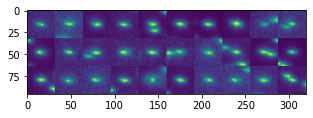

 13%|█▎        | 315/2493 [00:00<00:00, 3144.90it/s]

True: -748.0 Pred: [-756.5993] Closest ground truth -798.0










100%|██████████| 2493/2493 [00:00<00:00, 3154.86it/s]


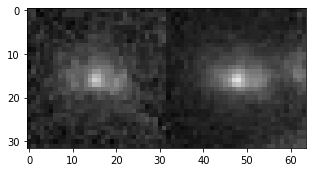

Rows 3 Cols 10 n_spaces 30 n_psfs 24


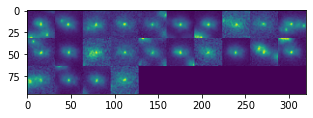

 13%|█▎        | 318/2493 [00:00<00:00, 3176.61it/s]

True: -1039.0 Pred: [-998.3884] Closest ground truth -809.0










100%|██████████| 2493/2493 [00:00<00:00, 3180.15it/s]


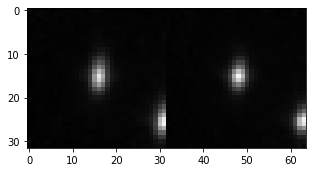

Rows 3 Cols 10 n_spaces 30 n_psfs 29


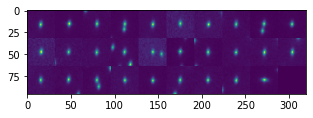

 12%|█▏        | 309/2493 [00:00<00:00, 3085.16it/s]

True: 95.0 Pred: [115.59231] Closest ground truth -5.0










100%|██████████| 2493/2493 [00:00<00:00, 3137.41it/s]


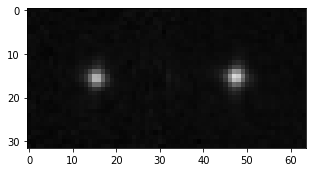

Rows 4 Cols 10 n_spaces 40 n_psfs 31


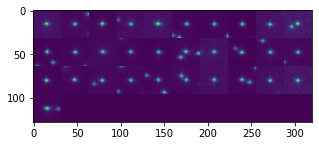

 12%|█▏        | 309/2493 [00:00<00:00, 3082.61it/s]

True: -239.0 Pred: [-154.747] Closest ground truth -131.0










100%|██████████| 2493/2493 [00:00<00:00, 3130.93it/s]


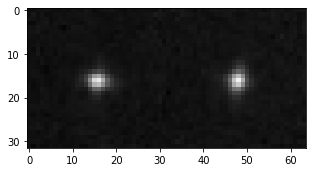

Rows 3 Cols 10 n_spaces 30 n_psfs 22


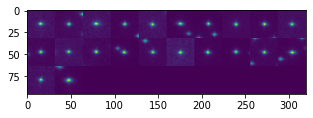

 12%|█▏        | 309/2493 [00:00<00:00, 3081.60it/s]

True: -227.0 Pred: [-270.46677] Closest ground truth -77.0










100%|██████████| 2493/2493 [00:00<00:00, 3100.42it/s]


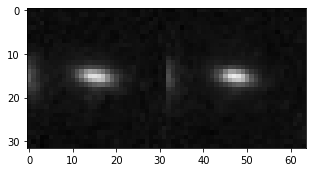

Rows 4 Cols 10 n_spaces 40 n_psfs 31


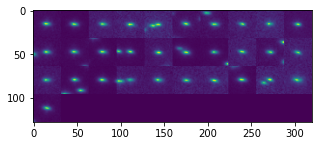

 12%|█▏        | 311/2493 [00:00<00:00, 3106.11it/s]

True: -531.0000000000002 Pred: [-532.4112] Closest ground truth -481.0000000000002










100%|██████████| 2493/2493 [00:00<00:00, 3129.95it/s]


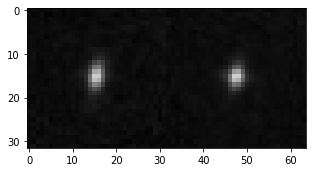

Rows 3 Cols 10 n_spaces 30 n_psfs 21


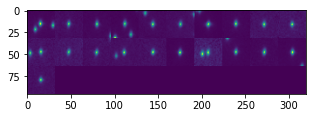

 13%|█▎        | 318/2493 [00:00<00:00, 3172.10it/s]

True: 67.0 Pred: [128.26196] Closest ground truth -83.0










100%|██████████| 2493/2493 [00:00<00:00, 3169.84it/s]


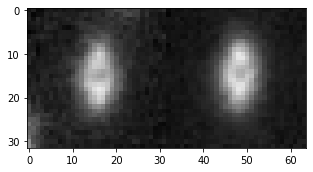

Rows 4 Cols 10 n_spaces 40 n_psfs 31


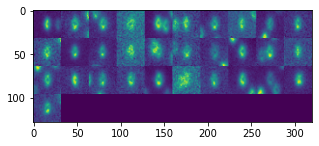

 13%|█▎        | 319/2493 [00:00<00:00, 3186.24it/s]

True: 659.0 Pred: [662.9997] Closest ground truth 744.0










100%|██████████| 2493/2493 [00:00<00:00, 3209.76it/s]


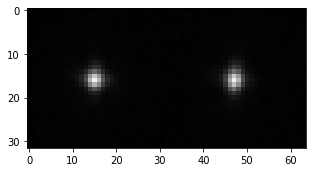

Rows 3 Cols 10 n_spaces 30 n_psfs 27


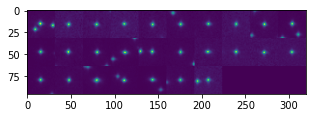

 13%|█▎        | 316/2493 [00:00<00:00, 3156.73it/s]

True: -130.0 Pred: [-77.13425] Closest ground truth -30.0










100%|██████████| 2493/2493 [00:00<00:00, 3164.55it/s]


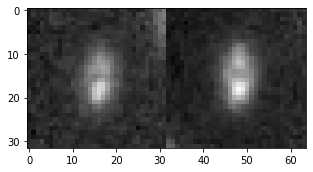

Rows 3 Cols 10 n_spaces 30 n_psfs 25


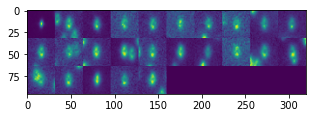

 13%|█▎        | 317/2493 [00:00<00:00, 3168.02it/s]

True: 600.0 Pred: [547.5427] Closest ground truth 525.0










100%|██████████| 2493/2493 [00:00<00:00, 3174.50it/s]


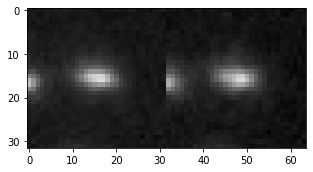

Rows 3 Cols 10 n_spaces 30 n_psfs 24


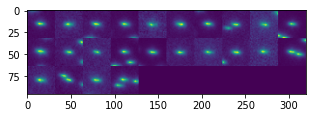

 12%|█▏        | 309/2493 [00:00<00:00, 3081.03it/s]

True: -642.0000000000002 Pred: [-642.20984] Closest ground truth -692.0000000000002










100%|██████████| 2493/2493 [00:00<00:00, 3209.23it/s]


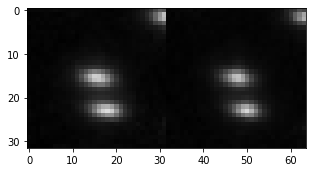

Rows 3 Cols 10 n_spaces 30 n_psfs 30


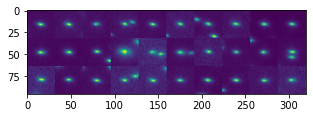

 13%|█▎        | 325/2493 [00:00<00:00, 3241.13it/s]

True: -503.0 Pred: [-496.53302] Closest ground truth -453.0










100%|██████████| 2493/2493 [00:00<00:00, 3265.78it/s]


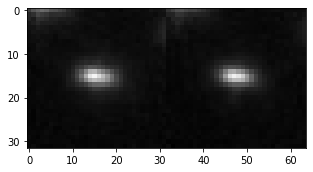

Rows 3 Cols 10 n_spaces 30 n_psfs 29


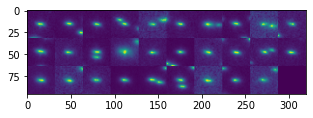

 13%|█▎        | 323/2493 [00:00<00:00, 3220.21it/s]

True: -602.0 Pred: [-563.5005] Closest ground truth -552.0










100%|██████████| 2493/2493 [00:00<00:00, 3263.26it/s]


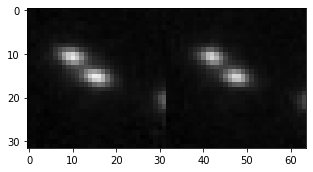

Rows 4 Cols 10 n_spaces 40 n_psfs 32


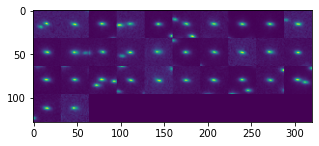

 13%|█▎        | 331/2493 [00:00<00:00, 3301.02it/s]

True: -493.0 Pred: [-477.0939] Closest ground truth -443.0










100%|██████████| 2493/2493 [00:00<00:00, 3261.33it/s]


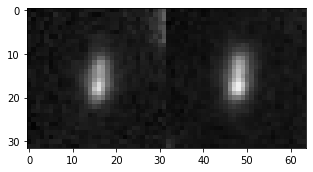

Rows 3 Cols 10 n_spaces 30 n_psfs 24


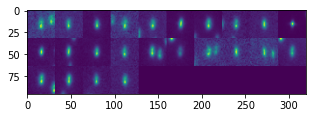

 13%|█▎        | 330/2493 [00:00<00:00, 3292.30it/s]

True: 450.0 Pred: [382.13477] Closest ground truth 375.0










100%|██████████| 2493/2493 [00:00<00:00, 3277.75it/s]


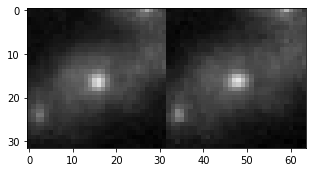

Rows 2 Cols 10 n_spaces 20 n_psfs 19


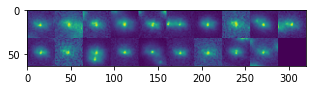

 13%|█▎        | 327/2493 [00:00<00:00, 3269.80it/s]

True: -971.0 Pred: [-992.1681] Closest ground truth -1021.0










100%|██████████| 2493/2493 [00:00<00:00, 3261.66it/s]


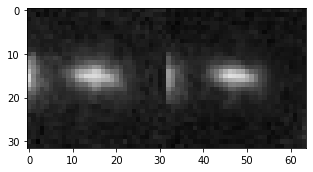

Rows 4 Cols 10 n_spaces 40 n_psfs 31


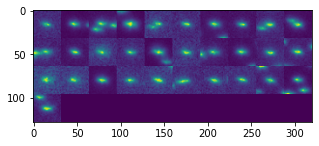

 13%|█▎        | 329/2493 [00:00<00:00, 3281.23it/s]

True: -731.0 Pred: [-725.35156] Closest ground truth -681.0000000000002










100%|██████████| 2493/2493 [00:00<00:00, 3299.83it/s]


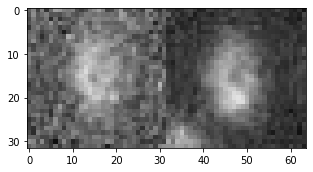

Rows 3 Cols 10 n_spaces 30 n_psfs 25


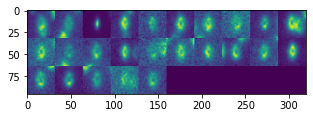

 13%|█▎        | 326/2493 [00:00<00:00, 3259.03it/s]

True: 798.0 Pred: [820.3449] Closest ground truth 833.0










100%|██████████| 2493/2493 [00:00<00:00, 3271.79it/s]


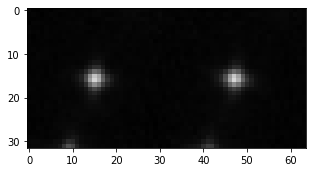

Rows 3 Cols 10 n_spaces 30 n_psfs 22


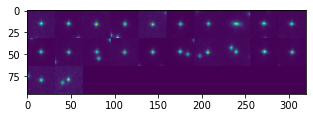

 13%|█▎        | 318/2493 [00:00<00:00, 3177.63it/s]

True: -149.0 Pred: [-141.2615] Closest ground truth -199.0










100%|██████████| 2493/2493 [00:00<00:00, 3254.87it/s]


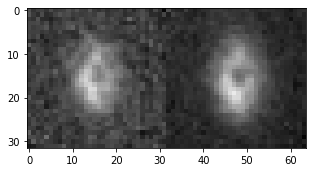

Rows 3 Cols 10 n_spaces 30 n_psfs 22


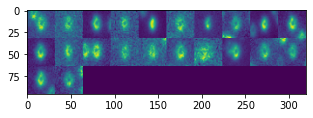

 13%|█▎        | 321/2493 [00:00<00:00, 3201.73it/s]

True: 772.0 Pred: [778.2304] Closest ground truth 843.0










100%|██████████| 2493/2493 [00:00<00:00, 3016.16it/s]


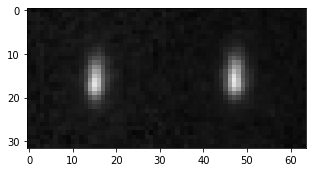

Rows 4 Cols 10 n_spaces 40 n_psfs 31


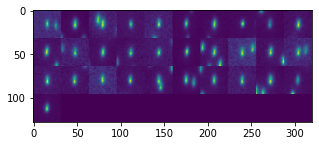

 13%|█▎        | 322/2493 [00:00<00:00, 3211.60it/s]

True: 350.0 Pred: [362.20923] Closest ground truth 514.0










100%|██████████| 2493/2493 [00:00<00:00, 3211.65it/s]


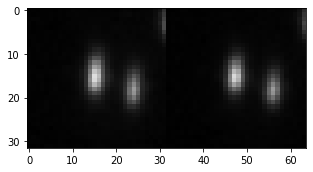

Rows 4 Cols 10 n_spaces 40 n_psfs 31


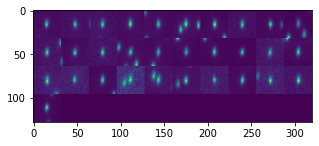

 13%|█▎        | 323/2493 [00:00<00:00, 3223.14it/s]

True: 257.0 Pred: [252.16406] Closest ground truth 207.0










100%|██████████| 2493/2493 [00:00<00:00, 3215.29it/s]


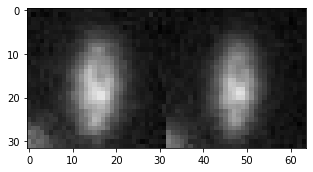

Rows 3 Cols 10 n_spaces 30 n_psfs 21


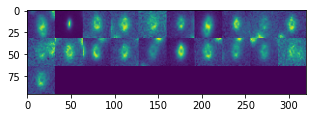

 13%|█▎        | 315/2493 [00:00<00:00, 3147.72it/s]

True: 790.0 Pred: [763.6272] Closest ground truth 740.0










100%|██████████| 2493/2493 [00:00<00:00, 3194.52it/s]


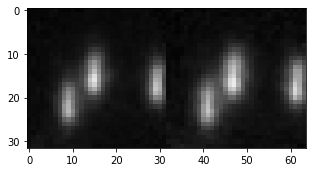

Rows 3 Cols 10 n_spaces 30 n_psfs 27


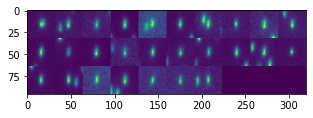

 13%|█▎        | 333/2493 [00:00<00:00, 3323.33it/s]

True: 361.99999999999955 Pred: [362.02823] Closest ground truth 411.99999999999955










100%|██████████| 2493/2493 [00:00<00:00, 3266.28it/s]


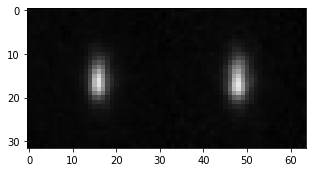

Rows 4 Cols 10 n_spaces 40 n_psfs 31


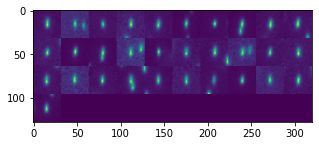

 13%|█▎        | 332/2493 [00:00<00:00, 3319.21it/s]

True: 343.0 Pred: [377.04816] Closest ground truth 393.0










100%|██████████| 2493/2493 [00:00<00:00, 3307.82it/s]


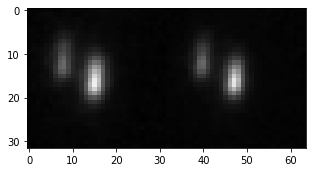

Rows 3 Cols 10 n_spaces 30 n_psfs 22


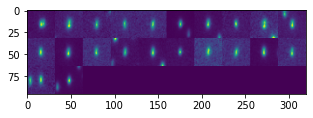

 13%|█▎        | 332/2493 [00:00<00:00, 3313.19it/s]

True: 370.0 Pred: [361.32922] Closest ground truth 320.0










100%|██████████| 2493/2493 [00:00<00:00, 3321.76it/s]


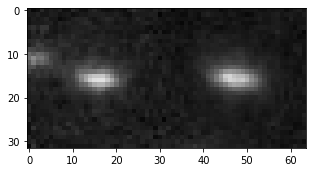

Rows 3 Cols 10 n_spaces 30 n_psfs 24


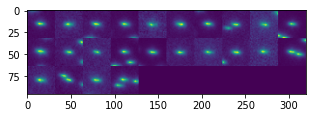

 13%|█▎        | 328/2493 [00:00<00:00, 3279.13it/s]

True: -642.0000000000002 Pred: [-618.6589] Closest ground truth -650.0










100%|██████████| 2493/2493 [00:00<00:00, 3321.01it/s]


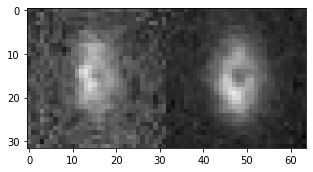

Rows 2 Cols 10 n_spaces 20 n_psfs 20


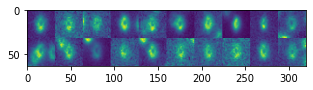

 13%|█▎        | 326/2493 [00:00<00:00, 3250.26it/s]

True: 818.0 Pred: [788.80554] Closest ground truth 843.0










100%|██████████| 2493/2493 [00:00<00:00, 3307.87it/s]


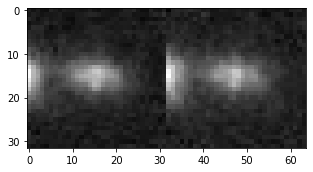

Rows 3 Cols 10 n_spaces 30 n_psfs 29


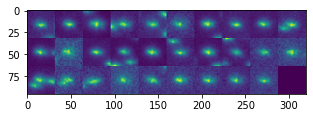

 13%|█▎        | 330/2493 [00:00<00:00, 3295.21it/s]

True: -831.0 Pred: [-815.13477] Closest ground truth -881.0










100%|██████████| 2493/2493 [00:00<00:00, 3306.74it/s]


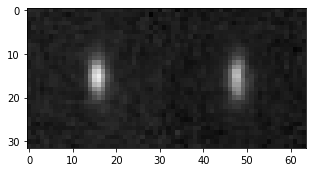

Rows 4 Cols 10 n_spaces 40 n_psfs 31


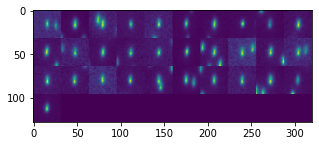

 13%|█▎        | 327/2493 [00:00<00:00, 3261.19it/s]

True: 350.0 Pred: [402.41943] Closest ground truth 375.0










100%|██████████| 2493/2493 [00:00<00:00, 3283.00it/s]


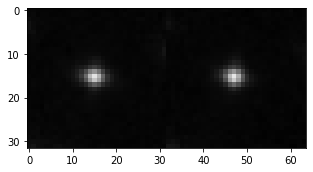

Rows 2 Cols 10 n_spaces 20 n_psfs 17


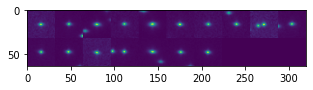

 13%|█▎        | 333/2493 [00:00<00:00, 3324.57it/s]

True: -275.9999999999998 Pred: [-233.0654] Closest ground truth -226.0










100%|██████████| 2493/2493 [00:00<00:00, 3283.48it/s]


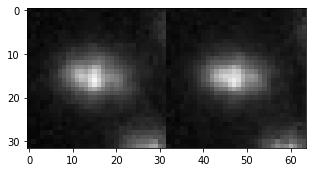

Rows 3 Cols 10 n_spaces 30 n_psfs 30


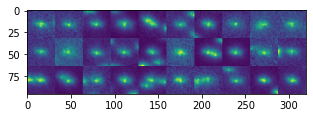

 13%|█▎        | 330/2493 [00:00<00:00, 3297.31it/s]

True: -884.0 Pred: [-879.13477] Closest ground truth -834.0










100%|██████████| 2493/2493 [00:00<00:00, 3276.61it/s]


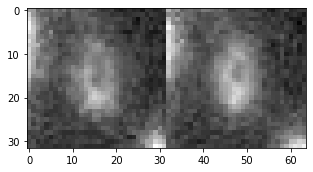

Rows 3 Cols 10 n_spaces 30 n_psfs 21


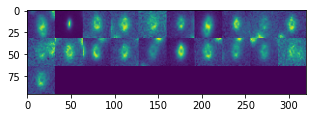

 13%|█▎        | 329/2493 [00:00<00:00, 3284.87it/s]

True: 790.0 Pred: [787.06006] Closest ground truth 740.0










100%|██████████| 2493/2493 [00:00<00:00, 3271.22it/s]


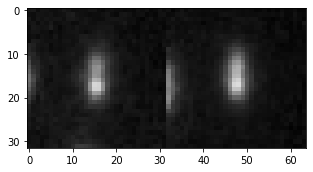

Rows 3 Cols 10 n_spaces 30 n_psfs 27


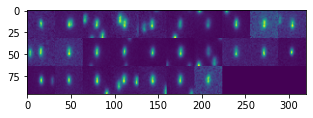

 13%|█▎        | 329/2493 [00:00<00:00, 3284.77it/s]

True: 408.0 Pred: [409.27438] Closest ground truth 428.0










100%|██████████| 2493/2493 [00:00<00:00, 3296.29it/s]


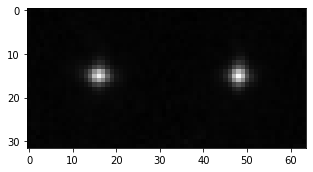

Rows 3 Cols 10 n_spaces 30 n_psfs 21


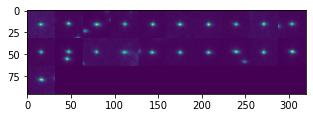

 13%|█▎        | 324/2493 [00:00<00:00, 3239.38it/s]

True: -266.0 Pred: [-179.1279] Closest ground truth -166.0










100%|██████████| 2493/2493 [00:00<00:00, 3314.90it/s]


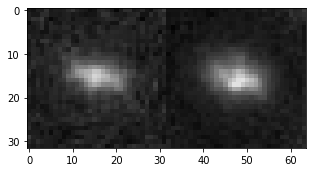

Rows 3 Cols 10 n_spaces 30 n_psfs 29


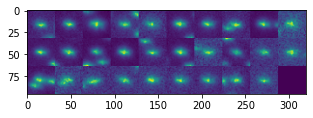

 13%|█▎        | 333/2493 [00:00<00:00, 3320.72it/s]

True: -833.0 Pred: [-804.4186] Closest ground truth -875.0










100%|██████████| 2493/2493 [00:00<00:00, 3305.66it/s]


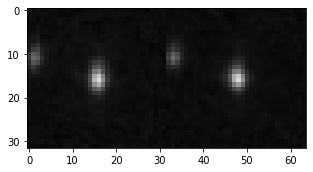

Rows 3 Cols 10 n_spaces 30 n_psfs 26


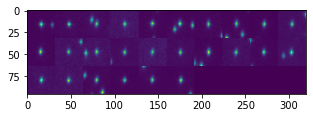

 13%|█▎        | 329/2493 [00:00<00:00, 3280.45it/s]

True: 58.0 Pred: [79.00213] Closest ground truth -42.0










100%|██████████| 2493/2493 [00:00<00:00, 3283.95it/s]


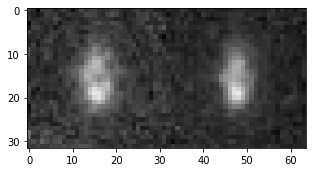

Rows 3 Cols 10 n_spaces 30 n_psfs 26


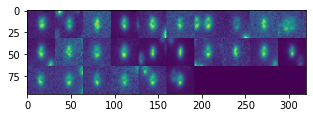

 13%|█▎        | 329/2493 [00:00<00:00, 3281.23it/s]

True: 621.0 Pred: [604.1581] Closest ground truth 550.0










100%|██████████| 2493/2493 [00:00<00:00, 3273.49it/s]


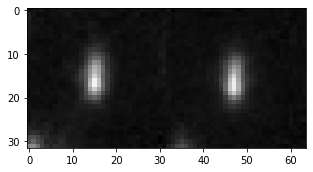

Rows 2 Cols 10 n_spaces 20 n_psfs 17


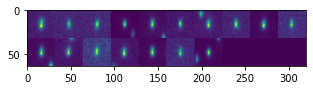

 13%|█▎        | 330/2493 [00:00<00:00, 3295.05it/s]

True: 374.0 Pred: [365.34976] Closest ground truth 383.0










100%|██████████| 2493/2493 [00:00<00:00, 3267.62it/s]


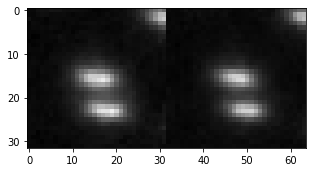

Rows 3 Cols 10 n_spaces 30 n_psfs 29


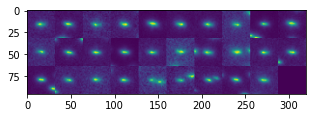

 13%|█▎        | 330/2493 [00:00<00:00, 3292.46it/s]

True: -653.0 Pred: [-626.1125] Closest ground truth -603.0










100%|██████████| 2493/2493 [00:00<00:00, 3299.52it/s]


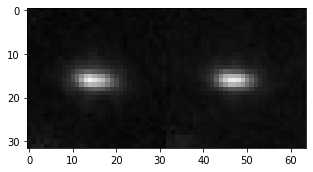

Rows 3 Cols 10 n_spaces 30 n_psfs 23


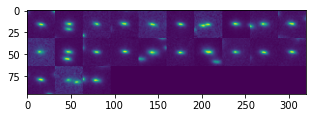

 13%|█▎        | 321/2493 [00:00<00:00, 3204.46it/s]

True: -567.0000000000002 Pred: [-585.1471] Closest ground truth -517.0000000000002










100%|██████████| 2493/2493 [00:00<00:00, 3186.26it/s]


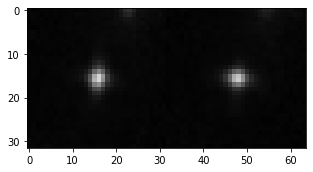

Rows 3 Cols 10 n_spaces 30 n_psfs 21


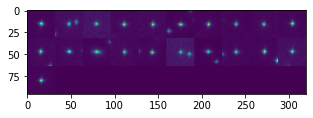

 13%|█▎        | 323/2493 [00:00<00:00, 3229.47it/s]

True: -113.00000000000045 Pred: [-22.879333] Closest ground truth -263.0000000000002










100%|██████████| 2493/2493 [00:00<00:00, 3226.46it/s]


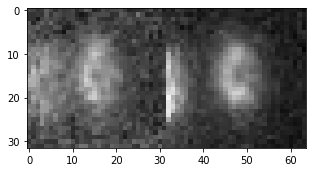

Rows 3 Cols 10 n_spaces 30 n_psfs 24


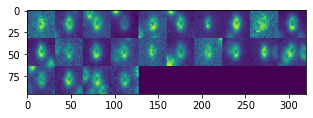

 13%|█▎        | 328/2493 [00:00<00:00, 3278.24it/s]

True: 761.0 Pred: [760.9091] Closest ground truth 728.0










100%|██████████| 2493/2493 [00:00<00:00, 3264.14it/s]


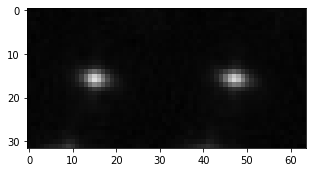

Rows 4 Cols 10 n_spaces 40 n_psfs 33


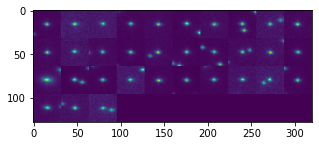

 13%|█▎        | 327/2493 [00:00<00:00, 3262.91it/s]

True: -299.0000000000002 Pred: [-307.65326] Closest ground truth -349.0000000000002










100%|██████████| 2493/2493 [00:00<00:00, 3281.01it/s]


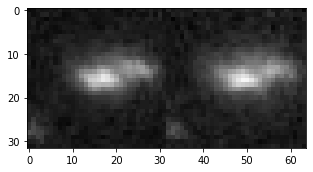

Rows 3 Cols 10 n_spaces 30 n_psfs 28


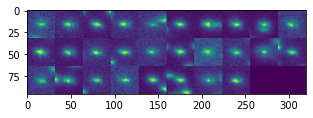

 13%|█▎        | 323/2493 [00:00<00:00, 3226.21it/s]

True: -804.0 Pred: [-792.96606] Closest ground truth -854.0










100%|██████████| 2493/2493 [00:00<00:00, 3270.72it/s]


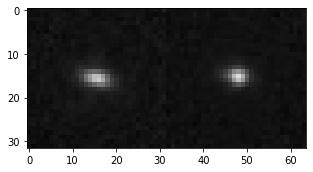

Rows 3 Cols 10 n_spaces 30 n_psfs 29


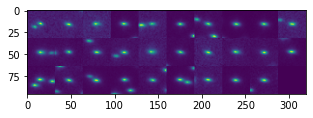

 13%|█▎        | 324/2493 [00:00<00:00, 3238.66it/s]

True: -489.0 Pred: [-421.0985] Closest ground truth -303.0










100%|██████████| 2493/2493 [00:00<00:00, 3277.27it/s]


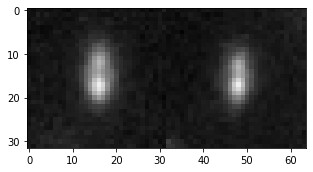

Rows 2 Cols 10 n_spaces 20 n_psfs 20


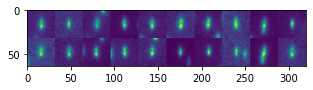

 13%|█▎        | 329/2493 [00:00<00:00, 3287.84it/s]

True: 484.0 Pred: [506.66992] Closest ground truth 425.0










100%|██████████| 2493/2493 [00:00<00:00, 3283.55it/s]


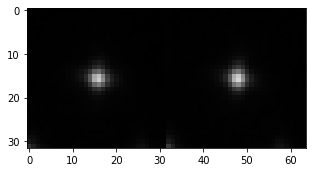

Rows 3 Cols 10 n_spaces 30 n_psfs 30


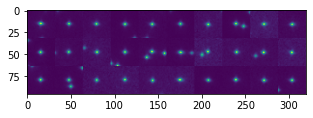

 13%|█▎        | 332/2493 [00:00<00:00, 3317.86it/s]

True: -194.0 Pred: [-140.63498] Closest ground truth -144.0










100%|██████████| 2493/2493 [00:00<00:00, 3293.33it/s]


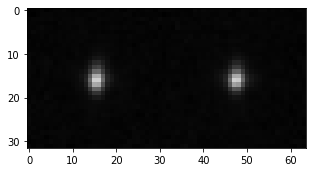

Rows 3 Cols 10 n_spaces 30 n_psfs 27


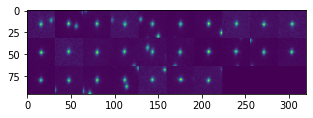

 13%|█▎        | 328/2493 [00:00<00:00, 3273.32it/s]

True: 0.0 Pred: [20.985344] Closest ground truth -50.0










100%|██████████| 2493/2493 [00:00<00:00, 3273.72it/s]


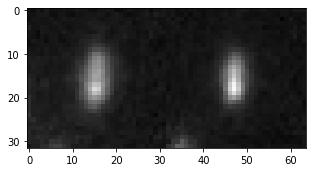

Rows 3 Cols 10 n_spaces 30 n_psfs 21


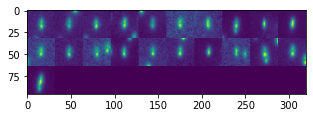

 13%|█▎        | 326/2493 [00:00<00:00, 3259.70it/s]

True: 490.0 Pred: [496.8745] Closest ground truth 433.0










100%|██████████| 2493/2493 [00:00<00:00, 3269.99it/s]


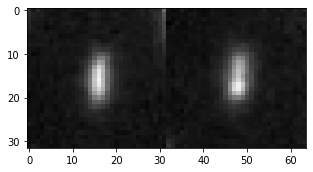

Rows 3 Cols 10 n_spaces 30 n_psfs 22


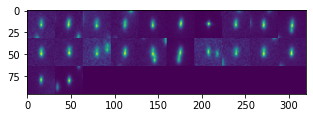

 13%|█▎        | 330/2493 [00:00<00:00, 3295.80it/s]

True: 388.00000000000045 Pred: [415.82452] Closest ground truth 375.0










100%|██████████| 2493/2493 [00:00<00:00, 3249.45it/s]


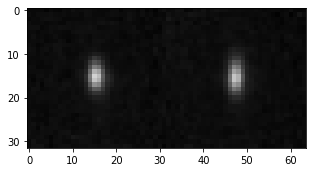

Rows 3 Cols 10 n_spaces 30 n_psfs 24


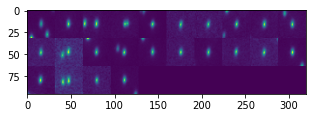

 13%|█▎        | 322/2493 [00:00<00:00, 3214.75it/s]

True: 218.0 Pred: [190.26135] Closest ground truth 188.00000000000045










100%|██████████| 2493/2493 [00:00<00:00, 3213.45it/s]


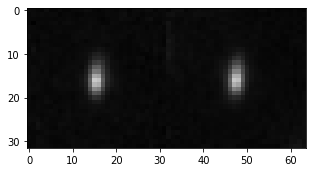

Rows 3 Cols 10 n_spaces 30 n_psfs 28


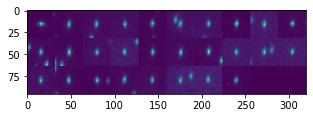

 13%|█▎        | 320/2493 [00:00<00:00, 3197.94it/s]

True: 150.0 Pred: [165.4061] Closest ground truth 140.0










100%|██████████| 2493/2493 [00:00<00:00, 3124.79it/s]


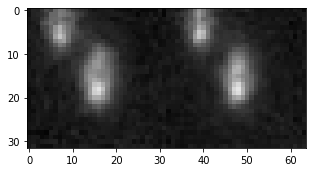

Rows 3 Cols 10 n_spaces 30 n_psfs 24


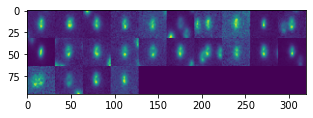

 13%|█▎        | 322/2493 [00:00<00:00, 3214.97it/s]

True: 568.0 Pred: [562.74335] Closest ground truth 518.0










In [ ]:
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
from data.visualise import grid_psfs

def do_ssim(data):
    i, i2, im1, im2 = data
    return i, i2, ssim(im1, im2, win_size=7)
def get_imgs_at_depth(z):
    idx = np.argwhere(abs(train_dataset.data['train'][1].squeeze()-z) < 10).squeeze()
    return train_dataset.data['train'][0][0][idx]


def find_most_similar_img(img):
    best_ssim = 0
    best_img = None
    best_img_idx = None
    for i, train_img in tqdm(enumerate(train_dataset.data['train'][0][0]), total=train_dataset.data['train'][0][0].shape[0]):
        val = ssim(img, train_img, win_size=3)
        if val > best_ssim:
            best_ssim = val
            best_img = train_img
            best_img_idx = i
    return best_img, best_img_idx

test_imgs, test_y = train_dataset.data['test'][0][0],  train_dataset.data['test'][1]
pred_y = model.predict((train_dataset.data['test'][0][0], train_dataset.data['test'][0][1]))
plt.rcParams['figure.figsize'] = [5, 5]
for img, true_z, pred_z in zip(test_imgs, test_y, pred_y):
    matched_img, i = find_most_similar_img(img)
    plt.imshow(np.concatenate((img, matched_img), axis=1))
    plt.show()
    plt.imshow(grid_psfs(get_imgs_at_depth(true_z).mean(axis=-1)))
    plt.show()

    print('True:', true_z, 'Pred:', pred_z, 'Closest ground truth', train_dataset.data['train'][1][i])
    print('\n\n\n\n\n\n\n')


In [ ]:
from skimage.metrics import structural_similarity as ssim, mean_squared_error
from tqdm import trange, tqdm
import numpy as np
from multiprocessing import Pool

def do_ssim(data):
    i, i2, im1, im2 = data
    return i, i2, ssim(im1, im2, win_size=7)

def get_pairwise_ssims(imgs):
    n_imgs = imgs.shape[0]

    datasets = []
    for i in range(0, n_imgs):
        for i2 in range(i, n_imgs):
            datasets.append((i, i2, imgs[i], imgs[i2]))

    with Pool(16) as p:
        r = list(p.imap(do_ssim, datasets))

    ssims = np.zeros((n_imgs, n_imgs))
    
    for res in r:
        i, i2, val = res
        ssims[i][i2] = val
        ssims[i2][i] = val
    return ssims
    

imgs = np.concatenate([train_dataset.data[k][0][0].squeeze() for k in ('train', 'test')])
zs = np.concatenate([train_dataset.data[k][1].squeeze() for k in ('train', 'test')])
from data.datasets import mask_img_stack
imgs = mask_img_stack(imgs, radius=8)

groups = dict()
for centre in np.arange(-1000, 1000, 200):
    idx = np.argwhere((abs(zs-centre) < 25))
    if idx.shape[0] > 0:
        if idx.shape[0] > 1:
            idx = idx.squeeze()
        groups[centre] = {
            'imgs': imgs[idx].squeeze(), 
            'zs': zs[idx].squeeze()
        }
        
from data.visualise import grid_psfs

for k, v in groups.items():
    ssims = get_pairwise_ssims(groups[k]['imgs'])
    groups[k]['mean_ssims'] = np.mean(ssims)
    groups[k]['std_ssims'] = np.std(ssims)
    if groups[k]['imgs'].ndim == 2:
        groups[k]['imgs'] = np.array([groups[k]['imgs']])
    print(groups[k]['imgs'].shape)
    plt.imshow(grid_psfs(groups[k]['imgs']))
    plt.show()
    print(k, np.mean(ssims), np.std(ssims))

        

# print(imgs.shape, zs.shape)



    

In [ ]:
from sklearn.cluster import OPTICS, DBSCAN
from sklearn.decomposition import PCA
clusters = OPTICS(metric='precomputed', min_samples=2).fit_predict(ssims)
print(set(clusters))
pca = PCA(n_components=2).fit_transform(ssims)
print(clusters.shape)
print(pca.shape)
print(zs.shape)